In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import hvplot.pandas
import scipy.stats as st
from scipy.stats import linregress
import folium
import numpy as np
from api_keys import geoapify_key
import requests
import json

In [2]:
crime_data = Path("Output/Crime_Reports.csv")

# Read in the data. 
crime_data_df = pd.read_csv(crime_data)
crime_data_df.sample(100)
crime_data_df.columns

C:\Users\Nomanos\AppData\Local\Temp\ipykernel_8484\181603860.py:4: DtypeWarning: Columns (16,26) have mixed types. Specify dtype option on import or set low_memory=False.
  crime_data_df = pd.read_csv(crime_data)


Index(['Incident Number', 'Highest Offense Description',
       'Highest Offense Code', 'Family Violence', 'Occurred Date Time',
       'Occurred Date', 'Occurred Time', 'Report Date Time', 'Report Date',
       'Report Time', 'Location Type', 'Address', 'Zip Code',
       'Council District', 'APD Sector', 'APD District', 'PRA', 'Census Tract',
       'Clearance Status', 'Clearance Date', 'UCR Category',
       'Category Description', 'X-coordinate', 'Y-coordinate', 'Latitude',
       'Longitude', 'Location'],
      dtype='object')

In [3]:
# Keep only certain columns
reduced_crime_df = crime_data_df.loc[:,['Highest Offense Description','Highest Offense Code','Occurred Date','Occurred Time','Location Type','Address','Latitude','Longitude','Zip Code','APD Sector','APD District','Clearance Status']]
reduced_crime_df

# Filter lat/long just for Austin area
clean_crime_loc_df = reduced_crime_df.loc[((crime_data_df["Latitude"] <= 31) & (crime_data_df["Latitude"] >= 30)) | 
                                       ((crime_data_df["Longitude"] <= -97.5) & (crime_data_df["Longitude"] >= -98)), :]
clean_crime_loc_df

Highest Offense Description  Highest Offense Code  \
36274                              BURGLARY OF VEHICLE                   601   
36275    BURGLARY OF SHED/DETACHED GARAGE/STORAGE UNIT                   504   
36277                                   THEFT OF METAL                   619   
36278                           DOC UNREASONABLE NOISE                  2405   
36279                                            THEFT                   600   
...                                                ...                   ...   
2371188                               DEBIT CARD ABUSE                  1108   
2371189                            BURGLARY OF VEHICLE                   601   
2371190                               PROTECTIVE ORDER                  3829   
2371191                    VIOL CITY ORDINANCE - OTHER                  3299   
2371192                            FORGERY AND PASSING                  1000   

        Occurred Date  Occurred Time                         Location Type  \
36274      12/01/2022         1130.0                      RESIDENCE / HOME   
36275      11/07/2022         2000.0             PARKING /DROP LOT/ GARAGE   
36277      12/01/2022         2327.0          COMMERCIAL / OFFICE BUILDING   
36278      12/03/2022          500.0                      RESIDENCE / HOME   
36279      10/29/2022         2300.0                      RESIDENCE / HOME   
...               ...            ...                                   ...   
2371188    09/24/2020         1200.0                       OTHER / UNKNOWN   
2371189    03/19/2010         1900.0                         FIELD / WOODS   
2371190    12/16/2008         1556.0                      RESIDENCE / HOME   
2371191    06/06/2010           31.0  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
2371192    08/25/2010         1605.0          COMMERCIAL / OFFICE BUILDING   

                       Address   Latitude  Longitude  Zip Code APD Sector  \
36274     1921 WILLOW CREEK DR  30.232680 -97.727425   78741.0         HE   
36275            4113 AVENUE F  30.304627 -97.729489   78751.0         BA   
36277             300 W 6TH ST  30.269110 -97.745659   78701.0         GE   
36278       11704 N LAMAR BLVD  30.386647 -97.684531   78758.0         ED   
36279             708 E 6TH ST  30.266186 -97.735585   78701.0         GE   
...                        ...        ...        ...       ...        ...   
2371188       3800 DROSSETT DR  30.211876 -97.731707   78744.0         FR   
2371189  2201 ANDREW ZILKER RD  30.265757 -97.770554   78746.0         DA   
2371190       1106 WEATHERS LN  30.239131 -97.770694   78704.0         DA   
2371191      675 E RUNDBERG LN  30.358489 -97.688952   78753.0         ED   
2371192        915 W OLTORF ST  30.243395 -97.764287   78704.0         DA   

        APD District Clearance Status  
36274              2                N  
36275              5              NaN  
36277              1                N  
36278              4                N  
36279              2                N  
...              ...              ...  
2371188            6                N  
2371189            1                N  
2371190            2              NaN  
2371191            1                C  
2371192            2                N  

[2333216 rows x 12 columns]

In [4]:
# Add empty columen for Occurred Year
clean_crime_loc_df.insert(3, "Occurred Date - Year", "")
clean_crime_loc_df

Highest Offense Description  Highest Offense Code  \
36274                              BURGLARY OF VEHICLE                   601   
36275    BURGLARY OF SHED/DETACHED GARAGE/STORAGE UNIT                   504   
36277                                   THEFT OF METAL                   619   
36278                           DOC UNREASONABLE NOISE                  2405   
36279                                            THEFT                   600   
...                                                ...                   ...   
2371188                               DEBIT CARD ABUSE                  1108   
2371189                            BURGLARY OF VEHICLE                   601   
2371190                               PROTECTIVE ORDER                  3829   
2371191                    VIOL CITY ORDINANCE - OTHER                  3299   
2371192                            FORGERY AND PASSING                  1000   

        Occurred Date Occurred Date - Year  Occurred Time  \
36274      12/01/2022                              1130.0   
36275      11/07/2022                              2000.0   
36277      12/01/2022                              2327.0   
36278      12/03/2022                               500.0   
36279      10/29/2022                              2300.0   
...               ...                  ...            ...   
2371188    09/24/2020                              1200.0   
2371189    03/19/2010                              1900.0   
2371190    12/16/2008                              1556.0   
2371191    06/06/2010                                31.0   
2371192    08/25/2010                              1605.0   

                                Location Type                Address  \
36274                        RESIDENCE / HOME   1921 WILLOW CREEK DR   
36275               PARKING /DROP LOT/ GARAGE          4113 AVENUE F   
36277            COMMERCIAL / OFFICE BUILDING           300 W 6TH ST   
36278                        RESIDENCE / HOME     11704 N LAMAR BLVD   
36279                        RESIDENCE / HOME           708 E 6TH ST   
...                                       ...                    ...   
2371188                       OTHER / UNKNOWN       3800 DROSSETT DR   
2371189                         FIELD / WOODS  2201 ANDREW ZILKER RD   
2371190                      RESIDENCE / HOME       1106 WEATHERS LN   
2371191  HWY / ROAD / ALLEY/ STREET/ SIDEWALK      675 E RUNDBERG LN   
2371192          COMMERCIAL / OFFICE BUILDING        915 W OLTORF ST   

          Latitude  Longitude  Zip Code APD Sector APD District  \
36274    30.232680 -97.727425   78741.0         HE            2   
36275    30.304627 -97.729489   78751.0         BA            5   
36277    30.269110 -97.745659   78701.0         GE            1   
36278    30.386647 -97.684531   78758.0         ED            4   
36279    30.266186 -97.735585   78701.0         GE            2   
...            ...        ...       ...        ...          ...   
2371188  30.211876 -97.731707   78744.0         FR            6   
2371189  30.265757 -97.770554   78746.0         DA            1   
2371190  30.239131 -97.770694   78704.0         DA            2   
2371191  30.358489 -97.688952   78753.0         ED            1   
2371192  30.243395 -97.764287   78704.0         DA            2   

        Clearance Status  
36274                  N  
36275                NaN  
36277                  N  
36278                  N  
36279                  N  
...                  ...  
2371188                N  
2371189                N  
2371190              NaN  
2371191                C  
2371192                N  

[2333216 rows x 13 columns]

In [5]:
# Split year from occured Date
for index, row in clean_crime_loc_df.iterrows():
    #Get occured date time
    try:
        clean_crime_loc_df.loc[index, "Occurred Date - Year"] = clean_crime_loc_df.loc[index, "Occurred Date"][-4:]
    except:
        clean_crime_loc_df.loc[index, "Occurred Date - Year"] = "NaN"

clean_crime_loc_df



Highest Offense Description  Highest Offense Code  \
36274                              BURGLARY OF VEHICLE                   601   
36275    BURGLARY OF SHED/DETACHED GARAGE/STORAGE UNIT                   504   
36277                                   THEFT OF METAL                   619   
36278                           DOC UNREASONABLE NOISE                  2405   
36279                                            THEFT                   600   
...                                                ...                   ...   
2371188                               DEBIT CARD ABUSE                  1108   
2371189                            BURGLARY OF VEHICLE                   601   
2371190                               PROTECTIVE ORDER                  3829   
2371191                    VIOL CITY ORDINANCE - OTHER                  3299   
2371192                            FORGERY AND PASSING                  1000   

        Occurred Date Occurred Date - Year  Occurred Time  \
36274      12/01/2022                 2022         1130.0   
36275      11/07/2022                 2022         2000.0   
36277      12/01/2022                 2022         2327.0   
36278      12/03/2022                 2022          500.0   
36279      10/29/2022                 2022         2300.0   
...               ...                  ...            ...   
2371188    09/24/2020                 2020         1200.0   
2371189    03/19/2010                 2010         1900.0   
2371190    12/16/2008                 2008         1556.0   
2371191    06/06/2010                 2010           31.0   
2371192    08/25/2010                 2010         1605.0   

                                Location Type                Address  \
36274                        RESIDENCE / HOME   1921 WILLOW CREEK DR   
36275               PARKING /DROP LOT/ GARAGE          4113 AVENUE F   
36277            COMMERCIAL / OFFICE BUILDING           300 W 6TH ST   
36278                        RESIDENCE / HOME     11704 N LAMAR BLVD   
36279                        RESIDENCE / HOME           708 E 6TH ST   
...                                       ...                    ...   
2371188                       OTHER / UNKNOWN       3800 DROSSETT DR   
2371189                         FIELD / WOODS  2201 ANDREW ZILKER RD   
2371190                      RESIDENCE / HOME       1106 WEATHERS LN   
2371191  HWY / ROAD / ALLEY/ STREET/ SIDEWALK      675 E RUNDBERG LN   
2371192          COMMERCIAL / OFFICE BUILDING        915 W OLTORF ST   

          Latitude  Longitude  Zip Code APD Sector APD District  \
36274    30.232680 -97.727425   78741.0         HE            2   
36275    30.304627 -97.729489   78751.0         BA            5   
36277    30.269110 -97.745659   78701.0         GE            1   
36278    30.386647 -97.684531   78758.0         ED            4   
36279    30.266186 -97.735585   78701.0         GE            2   
...            ...        ...       ...        ...          ...   
2371188  30.211876 -97.731707   78744.0         FR            6   
2371189  30.265757 -97.770554   78746.0         DA            1   
2371190  30.239131 -97.770694   78704.0         DA            2   
2371191  30.358489 -97.688952   78753.0         ED            1   
2371192  30.243395 -97.764287   78704.0         DA            2   

        Clearance Status  
36274                  N  
36275                NaN  
36277                  N  
36278                  N  
36279                  N  
...                  ...  
2371188                N  
2371189                N  
2371190              NaN  
2371191                C  
2371192                N  

[2333216 rows x 13 columns]

In [6]:
clean_crime_df = clean_crime_loc_df.dropna()
clean_crime_df

#clean_crime_df.to_csv("Output/crime_report_cleaned.csv", index=False, header=True)

Highest Offense Description  Highest Offense Code Occurred Date  \
36274            BURGLARY OF VEHICLE                   601    12/01/2022   
36277                 THEFT OF METAL                   619    12/01/2022   
36278         DOC UNREASONABLE NOISE                  2405    12/03/2022   
36279                          THEFT                   600    10/29/2022   
36280        CRED CARD ABUSE - OTHER                  1106    09/02/2022   
...                              ...                   ...           ...   
2371187                        THEFT                   600    10/08/2010   
2371188             DEBIT CARD ABUSE                  1108    09/24/2020   
2371189          BURGLARY OF VEHICLE                   601    03/19/2010   
2371191  VIOL CITY ORDINANCE - OTHER                  3299    06/06/2010   
2371192          FORGERY AND PASSING                  1000    08/25/2010   

        Occurred Date - Year  Occurred Time  \
36274                   2022         1130.0   
36277                   2022         2327.0   
36278                   2022          500.0   
36279                   2022         2300.0   
36280                   2022         2150.0   
...                      ...            ...   
2371187                 2010         1047.0   
2371188                 2020         1200.0   
2371189                 2010         1900.0   
2371191                 2010           31.0   
2371192                 2010         1605.0   

                                Location Type                Address  \
36274                        RESIDENCE / HOME   1921 WILLOW CREEK DR   
36277            COMMERCIAL / OFFICE BUILDING           300 W 6TH ST   
36278                        RESIDENCE / HOME     11704 N LAMAR BLVD   
36279                        RESIDENCE / HOME           708 E 6TH ST   
36280                        RESIDENCE / HOME     10208 IDA GROVE LN   
...                                       ...                    ...   
2371187                       OTHER / UNKNOWN  404 RALPH ABLANEDO DR   
2371188                       OTHER / UNKNOWN       3800 DROSSETT DR   
2371189                         FIELD / WOODS  2201 ANDREW ZILKER RD   
2371191  HWY / ROAD / ALLEY/ STREET/ SIDEWALK      675 E RUNDBERG LN   
2371192          COMMERCIAL / OFFICE BUILDING        915 W OLTORF ST   

          Latitude  Longitude  Zip Code APD Sector APD District  \
36274    30.232680 -97.727425   78741.0         HE            2   
36277    30.269110 -97.745659   78701.0         GE            1   
36278    30.386647 -97.684531   78758.0         ED            4   
36279    30.266186 -97.735585   78701.0         GE            2   
36280    30.502544 -97.753089   78717.0         AD            5   
...            ...        ...       ...        ...          ...   
2371187  30.174438 -97.792345   78748.0         FR            3   
2371188  30.211876 -97.731707   78744.0         FR            6   
2371189  30.265757 -97.770554   78746.0         DA            1   
2371191  30.358489 -97.688952   78753.0         ED            1   
2371192  30.243395 -97.764287   78704.0         DA            2   

        Clearance Status  
36274                  N  
36277                  N  
36278                  N  
36279                  N  
36280                  N  
...                  ...  
2371187                N  
2371188                N  
2371189                N  
2371191                C  
2371192                N  

[1721385 rows x 13 columns]

In [7]:
df_alcohol = clean_crime_df.loc[(clean_crime_df["Highest Offense Code"] == 2100) |
                              (clean_crime_df["Highest Offense Code"] == 2102) |
                              (clean_crime_df["Highest Offense Code"] == 2111) |
                              (clean_crime_df["Highest Offense Code"] == 2103) |
                              (clean_crime_df["Highest Offense Code"] == 2108) |
                              (clean_crime_df["Highest Offense Code"] == 3211) |
                              (clean_crime_df["Highest Offense Code"] == 2209) |
                              (clean_crime_df["Highest Offense Code"] == 2200) |
                              (clean_crime_df["Highest Offense Code"] == 2109) |
                              (clean_crime_df["Highest Offense Code"] == 2206) |
                              (clean_crime_df["Highest Offense Code"] == 2208) |
                              (clean_crime_df["Highest Offense Code"] == 2107) |
                              (clean_crime_df["Highest Offense Code"] == 2106) |
                              (clean_crime_df["Highest Offense Code"] == 2105) |
                              (clean_crime_df["Highest Offense Code"] == 108) |
                              (clean_crime_df["Highest Offense Code"] == 2110) |
                              (clean_crime_df["Highest Offense Code"] == 2202) |
                              (clean_crime_df["Highest Offense Code"] == 2203) |
                              (clean_crime_df["Highest Offense Code"] == 2104)
                              ,:]
df_alcohol.head()

Highest Offense Description  Highest Offense Code Occurred Date  \
36296                         DWI                  2100    12/10/2022   
36325                         DWI                  2100    12/09/2022   
36351                         DWI                  2100    12/04/2022   
36368       DWI  .15 BAC OR ABOVE                  2111    12/10/2022   
36374                         DWI                  2100    12/07/2022   

      Occurred Date - Year  Occurred Time  \
36296                 2022          204.0   
36325                 2022          237.0   
36351                 2022         2131.0   
36368                 2022           46.0   
36374                 2022           28.0   

                              Location Type               Address   Latitude  \
36296  HWY / ROAD / ALLEY/ STREET/ SIDEWALK  7800 S IH 35 SVRD NB  30.178919   
36325  HWY / ROAD / ALLEY/ STREET/ SIDEWALK     8319 N LAMAR BLVD  30.351584   
36351  HWY / ROAD / ALLEY/ STREET/ SIDEWALK     E 7TH ST / MEDINA  30.265674   
36368  HWY / ROAD / ALLEY/ STREET/ SIDEWALK  5100 N IH 35 SVRD SB  30.310594   
36374  HWY / ROAD / ALLEY/ STREET/ SIDEWALK         1515 W 5TH ST  30.273054   

       Longitude  Zip Code APD Sector APD District Clearance Status  
36296 -97.777859   78744.0         FR            7                C  
36325 -97.706977   78753.0         ED            1                C  
36351 -97.731094   78702.0         CH            2                C  
36368 -97.711861   78751.0         ID            6                C  
36374 -97.762886   78703.0         BA            2                C

In [8]:
df_mj= clean_crime_df.loc[(clean_crime_df["Highest Offense Code"] == 1803) |
                              (clean_crime_df["Highest Offense Code"] == 1825) |
                              (clean_crime_df["Highest Offense Code"] == 1807) |
                              (clean_crime_df["Highest Offense Code"] == 1826) |
                              (clean_crime_df["Highest Offense Code"] == 1827)
                              ,:]
df_mj.head()

Highest Offense Description  Highest Offense Code Occurred Date  \
36686     POSSESSION OF MARIJUANA                  1803    05/09/2006   
36785     POSSESSION OF MARIJUANA                  1803    12/02/2022   
36817     POSSESSION OF MARIJUANA                  1803    10/28/2022   
37018     POSSESSION OF MARIJUANA                  1803    10/18/2022   
37235     POSSESSION OF MARIJUANA                  1803    10/28/2022   

      Occurred Date - Year  Occurred Time  \
36686                 2006         1246.0   
36785                 2022         2018.0   
36817                 2022          331.0   
37018                 2022         1939.0   
37235                 2022          347.0   

                              Location Type                     Address  \
36686             PARKING /DROP LOT/ GARAGE            1300 E OLTORF ST   
36785                     CONVENIENCE STORE             102 W POWELL LN   
36817  HWY / ROAD / ALLEY/ STREET/ SIDEWALK  E 7TH ST / N IH 35 SVRD NB   
37018  HWY / ROAD / ALLEY/ STREET/ SIDEWALK  E 7TH ST / N IH 35 SVRD NB   
37235             PARKING /DROP LOT/ GARAGE            5001 CRAINWAY DR   

        Latitude  Longitude  Zip Code APD Sector APD District Clearance Status  
36686  30.234674 -97.743557   78704.0         HE            1                C  
36785  30.348014 -97.703338   78753.0         ED            1                N  
36817  30.266572 -97.733864   78701.0         CH            1                N  
37018  30.266572 -97.733864   78701.0         CH            1                N  
37235  30.319028 -97.657634   78724.0         CH            7                N

In [9]:
df_mj['Month']=pd.to_datetime(df_mj['Occurred Date']).dt.strftime('%m')
#df_mj.columns

df_alcohol['Month']=pd.to_datetime(df_alcohol['Occurred Date']).dt.strftime('%m')
df_alcohol.columns

C:\Users\Nomanos\AppData\Local\Temp\ipykernel_8484\2302078485.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mj['Month']=pd.to_datetime(df_mj['Occurred Date']).dt.strftime('%m')
C:\Users\Nomanos\AppData\Local\Temp\ipykernel_8484\2302078485.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alcohol['Month']=pd.to_datetime(df_alcohol['Occurred Date']).dt.strftime('%m')


Index(['Highest Offense Description', 'Highest Offense Code', 'Occurred Date',
       'Occurred Date - Year', 'Occurred Time', 'Location Type', 'Address',
       'Latitude', 'Longitude', 'Zip Code', 'APD Sector', 'APD District',
       'Clearance Status', 'Month'],
      dtype='object')

Month
01    424
02    402
03    402
04    384
05    399
06    353
07    389
08    318
09    376
10    356
11    306
12    341
Name: Highest Offense Description, dtype: int64


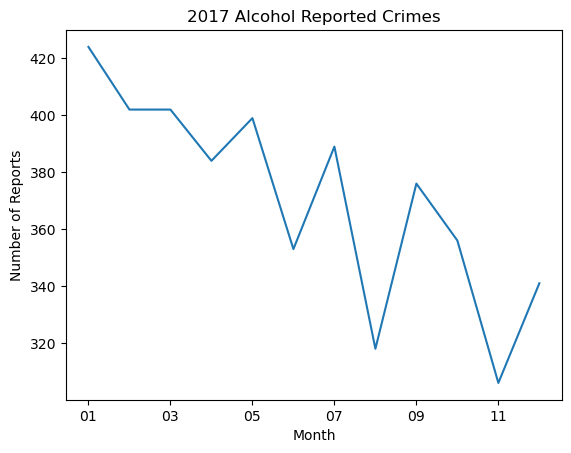

In [94]:
OHyear_2017=df_alcohol.loc[(df_alcohol['Occurred Date - Year'] == '2017')]


month_oh17=OHyear_2017.groupby(["Month"])['Highest Offense Description'].count().sort_index()
month_oh17.plot(kind='line').set(title= '2017 Alcohol Reported Crimes' )
print(month_oh17)
plt.ylabel("Number of Reports")
plt.savefig("Output/Fig8.png")

Month
01    259
02    190
03    225
04    270
05    227
06    206
07    218
08    223
09    159
10    192
11    202
12    167
Name: Highest Offense Description, dtype: int64


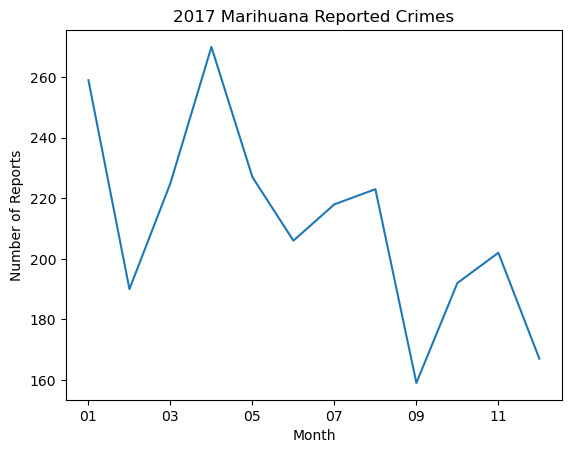

In [93]:
year_2017=df_mj.loc[(df_mj['Occurred Date - Year'] == '2017')]


month_mj17=year_2017.groupby(["Month"])['Highest Offense Description'].count().sort_index()
month_mj17.plot(kind='line').set(title= '2017 Marihuana Reported Crimes' )
print(month_mj17)
plt.ylabel("Number of Reports")
plt.savefig("Output/Fig3.png")

Month
01    424
02    402
03    402
04    384
05    399
06    353
07    389
08    318
09    376
10    356
11    306
12    341
Name: Highest Offense Description, dtype: int64


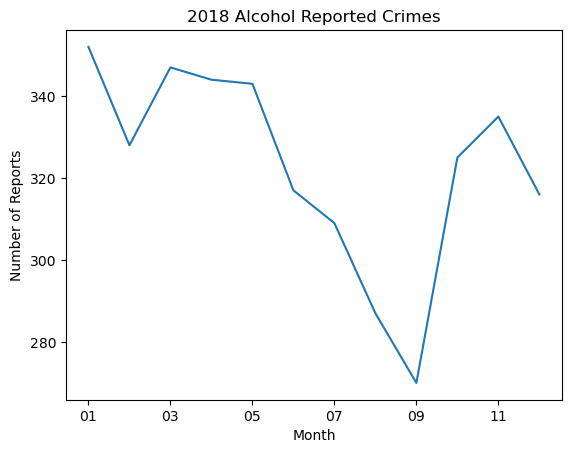

In [92]:
OHyear_2018=df_alcohol.loc[(df_alcohol['Occurred Date - Year'] == '2018')]


month_oh18=OHyear_2018.groupby(["Month"])['Highest Offense Description'].count().sort_index()
month_oh18.plot(kind='line').set(title= '2018 Alcohol Reported Crimes' )
print(month_oh17)
plt.ylabel("Number of Reports")
plt.savefig("Output/Fig9.png")

Month
01    307
02    277
03    325
04    256
05    312
06    271
07    270
08    320
09    261
10    288
11    275
12    297
Name: Highest Offense Description, dtype: int64


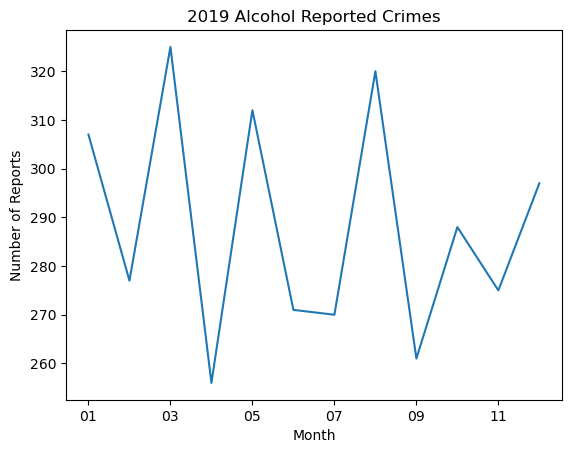

In [91]:
OHyear_2019=df_alcohol.loc[(df_alcohol['Occurred Date - Year'] == '2019')]


month_oh19=OHyear_2019.groupby(["Month"])['Highest Offense Description'].count().sort_index()
month_oh19.plot(kind='line').set(title= '2019 Alcohol Reported Crimes' )
print(month_oh19)
plt.ylabel("Number of Reports")
plt.savefig("Output/Fig10.png")

Month
01    286
02    310
03    247
04    136
05    223
06    140
07    129
08    169
09    194
10    251
11    242
12    239
Name: Highest Offense Description, dtype: int64


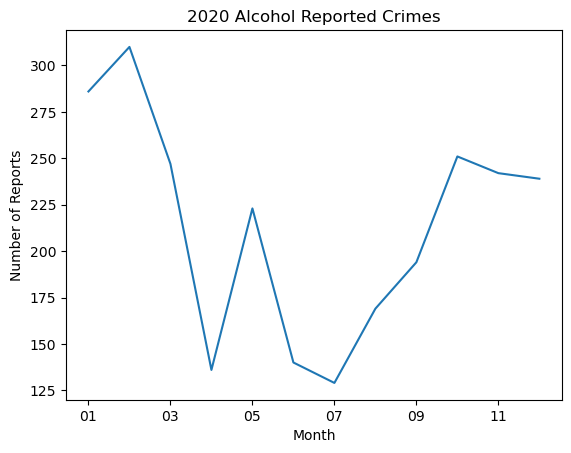

In [90]:
OHyear_2020=df_alcohol.loc[(df_alcohol['Occurred Date - Year'] == '2020')]


month_oh20=OHyear_2020.groupby(["Month"])['Highest Offense Description'].count().sort_index()
month_oh20.plot(kind='line').set(title= '2020 Alcohol Reported Crimes' )
print(month_oh20)
plt.ylabel("Number of Reports")
plt.savefig("Output/Fig11.png")

Month
01    234
02    176
03    250
04    195
05    206
06    193
07    182
08    212
09    201
10    204
11    173
12    210
Name: Highest Offense Description, dtype: int64


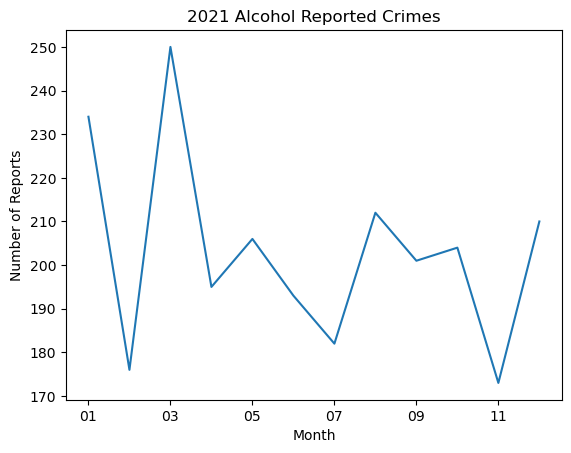

In [89]:
OHyear_2021=df_alcohol.loc[(df_alcohol['Occurred Date - Year'] == '2021')]


month_oh21=OHyear_2021.groupby(["Month"])['Highest Offense Description'].count().sort_index()
month_oh21.plot(kind='line').set(title= '2021 Alcohol Reported Crimes' )
print(month_oh21)
plt.ylabel("Number of Reports")
plt.savefig("Output/Fig12.png")

Month
01    181
02    195
03    202
04    214
05    186
06    156
07    145
08    133
09    139
10    158
11    155
12    125
Name: Highest Offense Description, dtype: int64


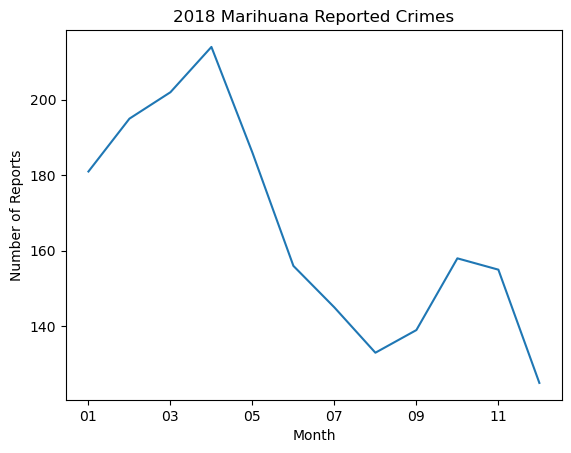

In [88]:
year_2018=df_mj.loc[(df_mj['Occurred Date - Year'] == '2018')]


month_mj18=year_2018.groupby(["Month"])['Highest Offense Description'].count().sort_index()
month_mj18.plot(kind='line').set(title= '2018 Marihuana Reported Crimes' )
print(month_mj18)
plt.ylabel("Number of Reports")
plt.savefig("Output/Fig4.png")

Month
01    145
02    125
03    164
04    119
05    124
06    106
07     68
08     88
09     70
10     74
11     77
12     88
Name: Highest Offense Description, dtype: int64


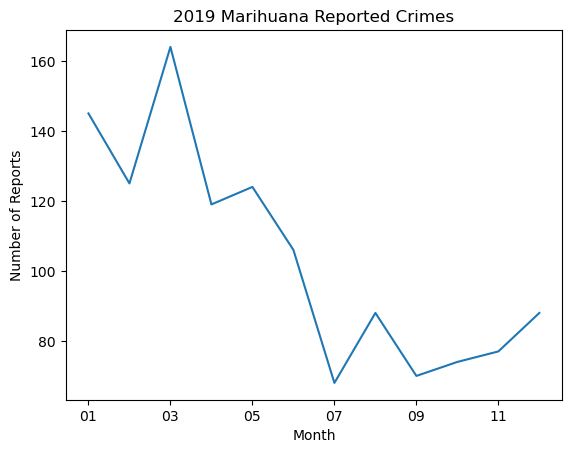

In [87]:
year_2019=df_mj.loc[(df_mj['Occurred Date - Year'] == '2019')]


month_mj19=year_2019.groupby(["Month"])['Highest Offense Description'].count().sort_index()
month_mj19.plot(kind='line').set(title= '2019 Marihuana Reported Crimes' )
print(month_mj19)
plt.ylabel("Number of Reports")
plt.savefig("Output/Fig5.png")

Month
01    79
02    87
03    80
04    56
05    79
06    19
07    30
08    26
09    28
10    43
11    25
12    42
Name: Highest Offense Description, dtype: int64


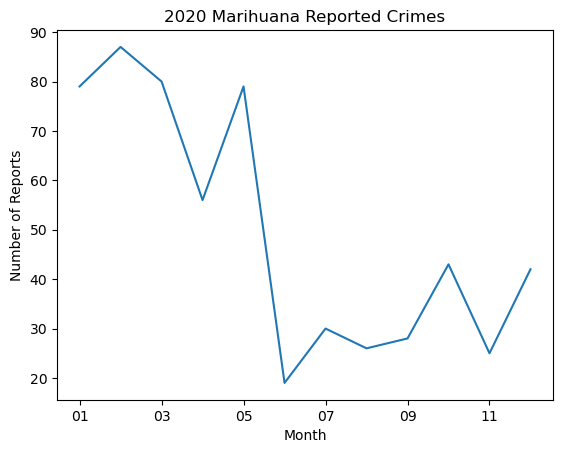

In [86]:
year_2020=df_mj.loc[(df_mj['Occurred Date - Year'] == '2020')]


month_mj20=year_2020.groupby(["Month"])['Highest Offense Description'].count().sort_index()
month_mj20.plot(kind='line').set(title= '2020 Marihuana Reported Crimes' )
print(month_mj20)
plt.ylabel("Number of Reports")
plt.savefig("Output/Fig6.png")

Month
01    79
02    87
03    80
04    56
05    79
06    19
07    30
08    26
09    28
10    43
11    25
12    42
Name: Highest Offense Description, dtype: int64


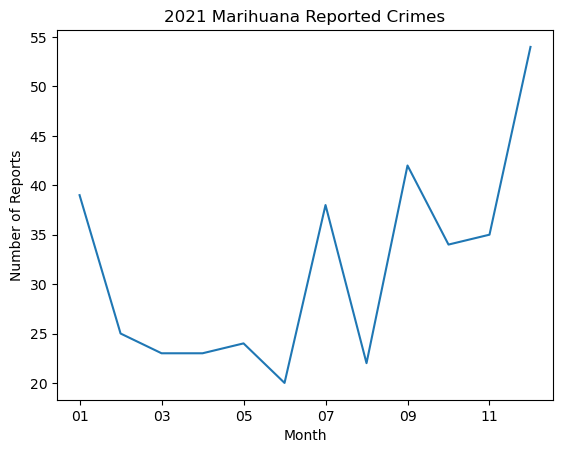

In [85]:
year_2021=df_mj.loc[(df_mj['Occurred Date - Year'] == '2021')]


month_mj21=year_2021.groupby(["Month"])['Highest Offense Description'].count().sort_index()
month_mj21.plot(kind='line').set(title= '2021 Marihuana Reported Crimes' )
print(month_mj17)
plt.ylabel("Number of Reports")
plt.savefig("Output/Fig7.png")

Month
01    43
02    32
03    54
04    37
05    36
06    40
07    27
08    45
09    33
10    53
11    34
12    50
Name: Highest Offense Description, dtype: int64


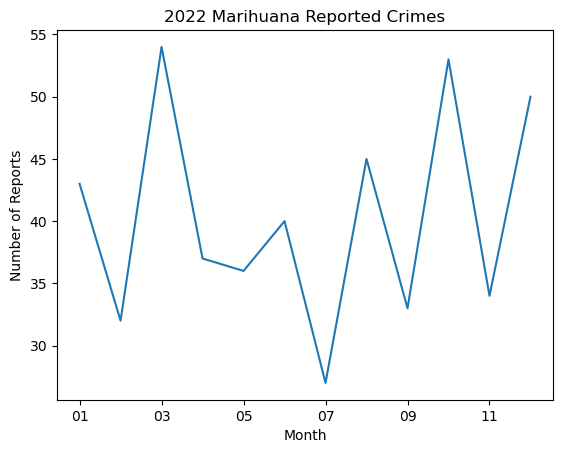

In [53]:
year_2022=df_mj.loc[(df_mj['Occurred Date - Year'] == '2022')]


month_mj22=year_2022.groupby(["Month"])['Highest Offense Description'].count().sort_index()
month_mj22.plot(kind='line').set(title= '2022 Marihuana Reported Crimes' )
print(month_mj22)
plt.ylabel("Number of Reports")
plt.savefig("Output/Fig19.png")

Month
01    208
02    199
03    213
04    255
05    229
06    236
07    243
08    233
09    197
10    221
11    187
12    221
Name: Highest Offense Description, dtype: int64


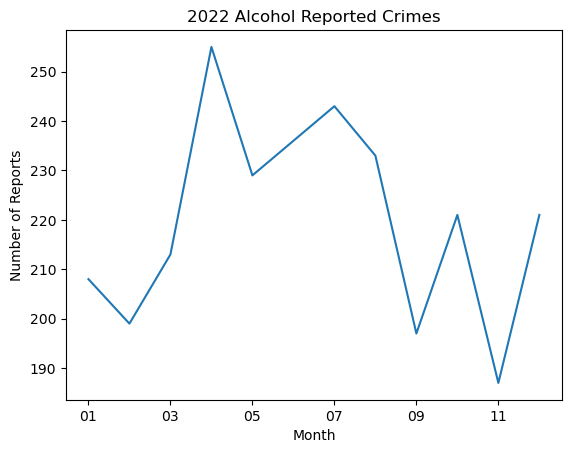

In [54]:
OHyear_2022=df_alcohol.loc[(df_alcohol['Occurred Date - Year'] == '2022')]


month_oh22=OHyear_2022.groupby(["Month"])['Highest Offense Description'].count().sort_index()
month_oh22.plot(kind='line').set(title= '2022 Alcohol Reported Crimes' )
print(month_oh22)
plt.ylabel("Number of Reports")
plt.savefig("Output/Fig20.png")

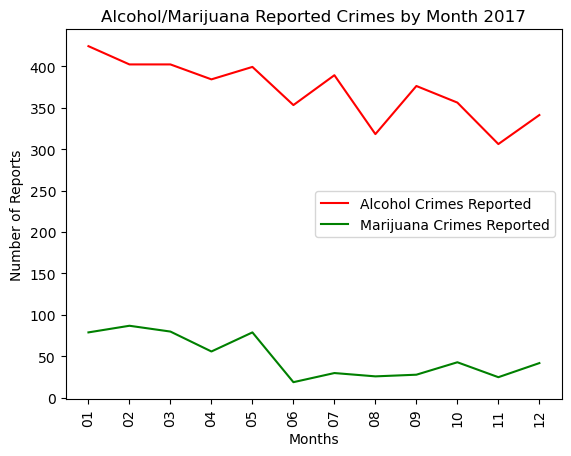

In [50]:
alc_crime17, = plt.plot(month_oh17.keys(), month_oh17, color='red', label="Alcohol Crimes Reported")
mj_crime17, = plt.plot(month_mj17.keys(), month_mj17, color='green', label="Marijuana Crimes Reported")
plt.xticks(rotation='vertical')
plt.legend(handles=[alc_crime17, mj_crime17], loc="center right")
plt.title("Alcohol/Marijuana Reported Crimes by Month 2017")
plt.ylabel("Number of Reports")
plt.xlabel("Months")
plt.savefig("Output/Fig17.png")

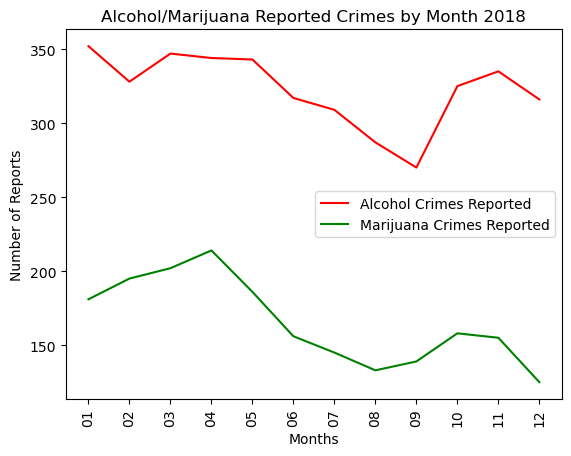

In [49]:
alc_crime18, = plt.plot(month_oh18.keys(), month_oh18, color='red', label="Alcohol Crimes Reported")
mj_crime18, = plt.plot(month_mj18.keys(), month_mj18, color='green', label="Marijuana Crimes Reported")
plt.xticks(rotation='vertical')
plt.legend(handles=[alc_crime18, mj_crime18], loc="center right")
plt.title("Alcohol/Marijuana Reported Crimes by Month 2018")
plt.ylabel("Number of Reports")
plt.xlabel("Months")
plt.savefig("Output/Fig16.png")

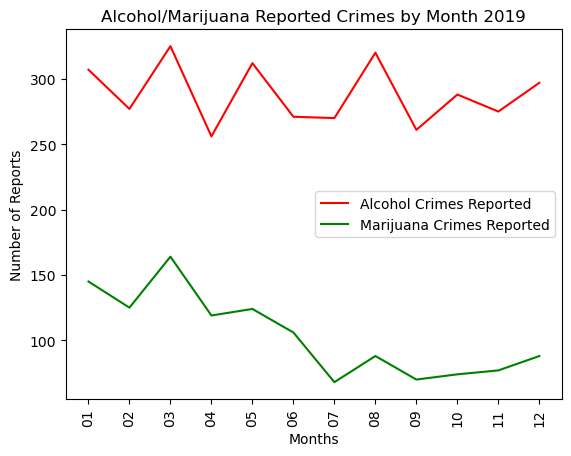

In [45]:
alc_crime19, = plt.plot(month_oh19.keys(), month_oh19, color='red', label="Alcohol Crimes Reported")
mj_crime19, = plt.plot(month_mj19.keys(), month_mj19, color='green', label="Marijuana Crimes Reported")
plt.xticks(rotation='vertical')
plt.legend(handles=[alc_crime19, mj_crime19], loc="center right")
plt.title("Alcohol/Marijuana Reported Crimes by Month 2019")
plt.ylabel("Number of Reports")
plt.xlabel("Months")
plt.savefig("Output/Fig14.png")

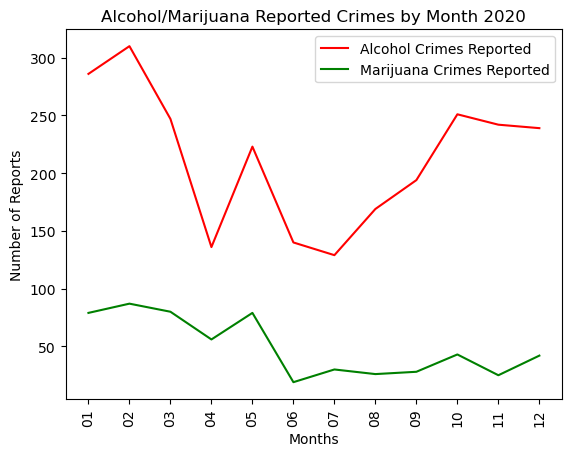

In [51]:
alc_crime20, = plt.plot(month_oh20.keys(), month_oh20, color='red', label="Alcohol Crimes Reported")
mj_crime20, = plt.plot(month_mj20.keys(), month_mj20, color='green', label="Marijuana Crimes Reported")
plt.xticks(rotation='vertical')
plt.legend(handles=[alc_crime20, mj_crime20], loc="upper right")
plt.title("Alcohol/Marijuana Reported Crimes by Month 2020")
plt.ylabel("Number of Reports")
plt.xlabel("Months")
plt.savefig("Output/Fig15.png")

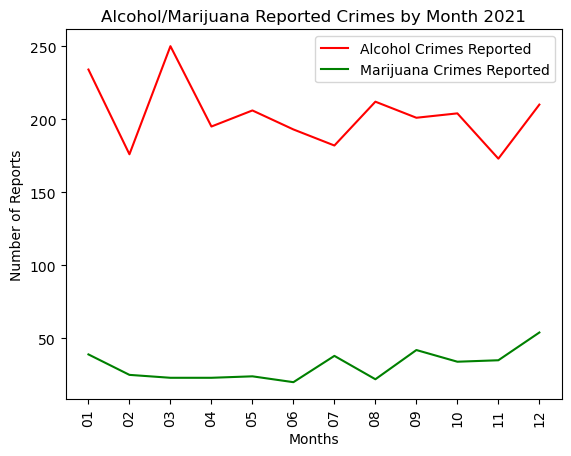

In [52]:
alc_crime21, = plt.plot(month_oh21.keys(), month_oh21, color='red', label="Alcohol Crimes Reported")
mj_crime21, = plt.plot(month_mj21.keys(), month_mj21, color='green', label="Marijuana Crimes Reported")
plt.xticks(rotation='vertical')
plt.legend(handles=[alc_crime21, mj_crime21], loc="upper right")
plt.title("Alcohol/Marijuana Reported Crimes by Month 2021")
plt.ylabel("Number of Reports")
plt.xlabel("Months")
plt.savefig("Output/Fig18.png")

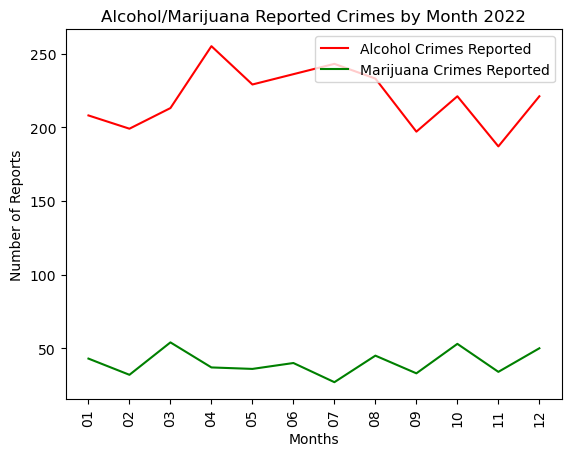

In [55]:
alc_crime22, = plt.plot(month_oh22.keys(), month_oh22, color='red', label="Alcohol Crimes Reported")
mj_crime22, = plt.plot(month_mj22.keys(), month_mj22, color='green', label="Marijuana Crimes Reported")
plt.xticks(rotation='vertical')
plt.legend(handles=[alc_crime22, mj_crime22], loc="upper right")
plt.title("Alcohol/Marijuana Reported Crimes by Month 2022")
plt.ylabel("Number of Reports")
plt.xlabel("Months")
plt.savefig("Output/Fig21.png")

In [80]:
OH_crime_count_zc19=OHyear_2019["Zip Code"].value_counts().sort_index()
mj_crime_count_zc19=year_2019["Zip Code"].value_counts().sort_index()
mj_oh19=pd.DataFrame({"Marihuana":mj_crime_count_zc19,"Alcohol":OH_crime_count_zc19})
mj_oh19.fillna(0, inplace=True)


In [83]:
OH_crime_count_zc19.sort_values(ascending=False)

78701.0    388
78704.0    281
78741.0    271
78758.0    246
78753.0    211
78744.0    181
78745.0    178
78703.0    167
78752.0    150
78759.0    138
78702.0    121
78748.0    110
78723.0    105
78750.0     69
78705.0     67
78731.0     66
78749.0     56
78727.0     51
78757.0     50
78751.0     50
78724.0     48
78729.0     47
78722.0     45
78721.0     42
78746.0     39
78735.0     39
78754.0     33
78717.0     33
78756.0     31
78747.0     29
78617.0     19
78613.0     18
78660.0     15
78726.0     11
78719.0      8
78736.0      8
78728.0      7
78742.0      6
78725.0      6
78739.0      4
78712.0      4
78653.0      4
78730.0      3
78732.0      2
78733.0      1
78610.0      1
Name: Zip Code, dtype: int64

In [84]:
mj_crime_count_zc19.sort_values(ascending=False)

78741.0    148
78701.0    146
78744.0    111
78758.0     97
78723.0     94
78753.0     82
78745.0     82
78702.0     76
78721.0     67
78704.0     57
78752.0     50
78748.0     29
78724.0     25
78759.0     22
78751.0     18
78617.0     15
78719.0     15
78757.0     13
78705.0     12
78727.0     12
78750.0      8
78749.0      8
78729.0      8
78731.0      8
78722.0      7
78756.0      7
78747.0      5
78725.0      5
78660.0      5
78703.0      3
78754.0      3
78746.0      2
78739.0      2
78735.0      2
78728.0      1
78717.0      1
78653.0      1
78726.0      1
Name: Zip Code, dtype: int64

The r-value is: 0.7281015522713343


<function matplotlib.pyplot.show(close=None, block=None)>

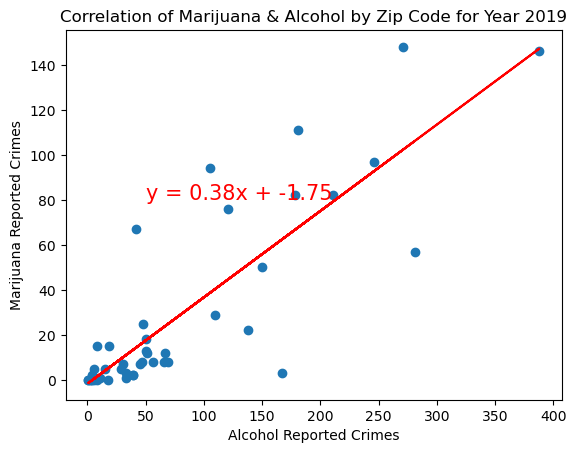

In [76]:
y=mj_oh19["Marihuana"].astype('float')
x=mj_oh19["Alcohol"].astype('float')

#linear regression
(slope,intercept,rvalue,pvalue,stderr)= linregress(x,y)
regress_values= x * slope + intercept
line_eq="y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

#plot
plt.scatter(x,y)
plt.plot(x,regress_values, "r-")
plt.title("Correlation of Marijuana & Alcohol by Zip Code for Year 2019")
plt.xlabel("Alcohol Reported Crimes")
plt.ylabel("Marijuana Reported Crimes")
plt.annotate(line_eq,(50,80),fontsize=15,color="red")
#R value
print(f"The r-value is: {rvalue**2}")
#save image
plt.savefig("Output/Fig23.png")
plt.show

In [81]:
#Determine Correlation
y=mj_oh19["Marihuana"]
x=mj_oh19["Alcohol"]
correlation= st.pearsonr(x,y)
print(f"The correlation between both is {round(correlation[0],2)}")

The correlation between both is 0.85


In [21]:
cmonth_mj19=year_2019["Month"].value_counts().sort_index()
#month_mj19
cmonth_oh19=OHyear_2019["Month"].value_counts().sort_index()

In [72]:
month_mj_oh19=pd.DataFrame({"Marihuana":cmonth_mj19,"Alcohol":cmonth_oh19})
month_mj_oh19.fillna(0, inplace=True)
month_mj_oh19


Marihuana  Alcohol
01        145      307
02        125      277
03        164      325
04        119      256
05        124      312
06        106      271
07         68      270
08         88      320
09         70      261
10         74      288
11         77      275
12         88      297

The r-value is: 0.24040150301917296


<function matplotlib.pyplot.show(close=None, block=None)>

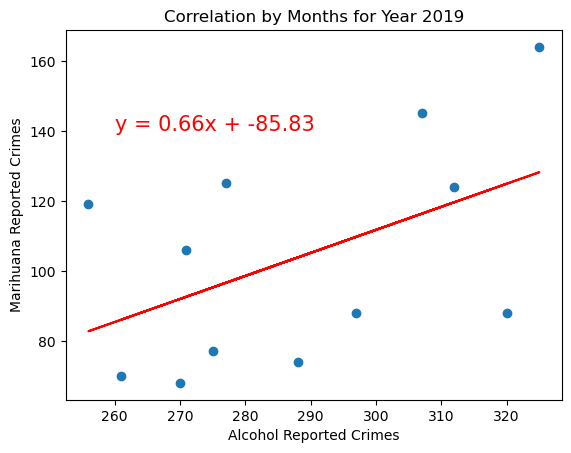

In [73]:
y=month_mj_oh19["Marihuana"].astype('float')
x=month_mj_oh19["Alcohol"].astype('float')

#linear regression
(slope,intercept,rvalue,pvalue,stderr)= linregress(x,y)
regress_values= x * slope + intercept
line_eq="y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

#plot
plt.scatter(x,y)
plt.plot(x,regress_values, "r-")
plt.title("Correlation by Months for Year 2019")
plt.xlabel("Alcohol Reported Crimes")
plt.ylabel("Marihuana Reported Crimes")
plt.annotate(line_eq,(260,140),fontsize=15,color="red")
#R value
print(f"The r-value is: {rvalue**2}")
#save image
plt.savefig("Output/Fig13.png")
plt.show

In [74]:
#Determine Correlation
y=month_mj_oh19["Marihuana"]
x=month_mj_oh19["Alcohol"]
correlation= st.pearsonr(x,y)
print(f"The correlation between both is {round(correlation[0],2)}")

The correlation between both is 0.49


In [36]:
OH_crime_count_zc20=OHyear_2020["Zip Code"].value_counts().sort_index()
mj_crime_count_zc20=year_2020["Zip Code"].value_counts().sort_index()
mj_oh20=pd.DataFrame({"Marihuana":mj_crime_count_zc20,"Alcohol":OH_crime_count_zc20})
mj_oh20.fillna(0, inplace=True)
mj_oh20.head()

Marihuana  Alcohol
78610.0        0.0      2.0
78613.0        0.0      9.0
78617.0        3.0     17.0
78652.0        1.0      0.0
78653.0        1.0      5.0

The r-value is: 0.7194959711099004


<function matplotlib.pyplot.show(close=None, block=None)>

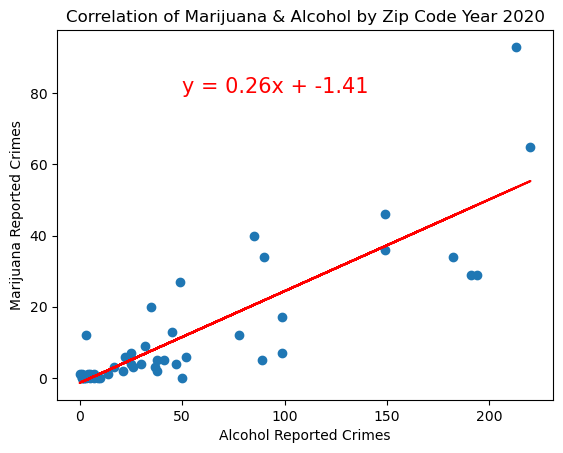

In [67]:
y=mj_oh20["Marihuana"].astype('float')
x=mj_oh20["Alcohol"].astype('float')

#linear regression
(slope,intercept,rvalue,pvalue,stderr)= linregress(x,y)
regress_values= x * slope + intercept
line_eq="y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

#plot
plt.scatter(x,y)
plt.plot(x,regress_values, "r-")
plt.title("Correlation of Marijuana & Alcohol by Zip Code Year 2020")
plt.xlabel("Alcohol Reported Crimes")
plt.ylabel("Marijuana Reported Crimes")
plt.annotate(line_eq,(50,80),fontsize=15,color="red")
#R value
print(f"The r-value is: {rvalue**2}")
#save image
plt.savefig("Output/Fig2.png")
plt.show

In [70]:
#Determine Correlation
y=mj_oh20["Marihuana"]
x=mj_oh20["Alcohol"]
correlation= st.pearsonr(x,y)
print(f"The correlation between both is {round(correlation[0],2)}")

The correlation between both is 0.85


In [62]:
OH_crime_count_zc22=OHyear_2022["Zip Code"].value_counts().sort_index()
mj_crime_count_zc22=year_2022["Zip Code"].value_counts().sort_index()
mj_oh22=pd.DataFrame({"Marihuana":mj_crime_count_zc22,"Alcohol":OH_crime_count_zc22})
mj_oh22.fillna(0, inplace=True)
#mj_oh22.head()


The r-value is: 0.5351193637789402


<function matplotlib.pyplot.show(close=None, block=None)>

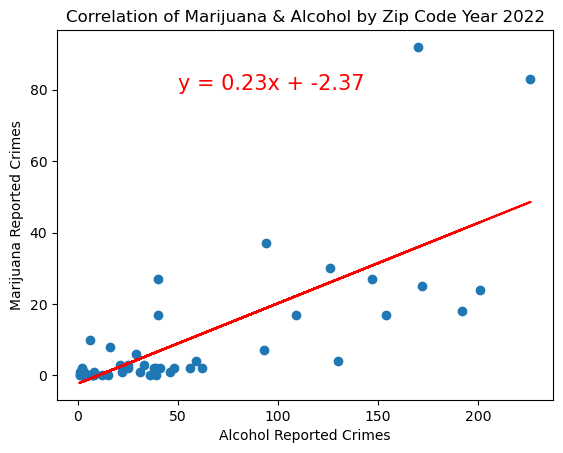

In [66]:
y=mj_oh22["Marihuana"].astype('float')
x=mj_oh22["Alcohol"].astype('float')

#linear regression
(slope,intercept,rvalue,pvalue,stderr)= linregress(x,y)
regress_values= x * slope + intercept
line_eq="y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

#plot
plt.scatter(x,y)
plt.plot(x,regress_values, "r-")
plt.title("Correlation of Marijuana & Alcohol by Zip Code Year 2022")
plt.xlabel("Alcohol Reported Crimes")
plt.ylabel("Marijuana Reported Crimes")
plt.annotate(line_eq,(50,80),fontsize=15,color="red")
#R value
print(f"The r-value is: {rvalue**2}")
#save image
plt.savefig("Output/Fig22.png")
plt.show

In [69]:
#Determine Correlation
y=mj_oh22["Marihuana"]
x=mj_oh22["Alcohol"]
correlation= st.pearsonr(x,y)
print(f"The correlation between both is {round(correlation[0],2)}")

The correlation between both is 0.73


In [65]:
OH_crime_count_zc=df_alcohol["Zip Code"].value_counts().sort_index()
mj_crime_count_zc=df_mj["Zip Code"].value_counts().sort_index()
mj_oh=pd.DataFrame({"Marihuana":mj_crime_count_zc,"Alcohol":OH_crime_count_zc})
mj_oh.fillna(0, inplace=True)
#mj_oh.head()


In [28]:
mj_oh.describe()

Marihuana       Alcohol
count    60.000000     60.000000
mean    521.816667   1569.933333
std     899.032502   2558.749323
min       0.000000      1.000000
25%       6.750000     25.500000
50%     109.500000    445.500000
75%     554.250000   1761.750000
max    3682.000000  12011.000000

The r-value is: 0.8679671222496459


<function matplotlib.pyplot.show(close=None, block=None)>

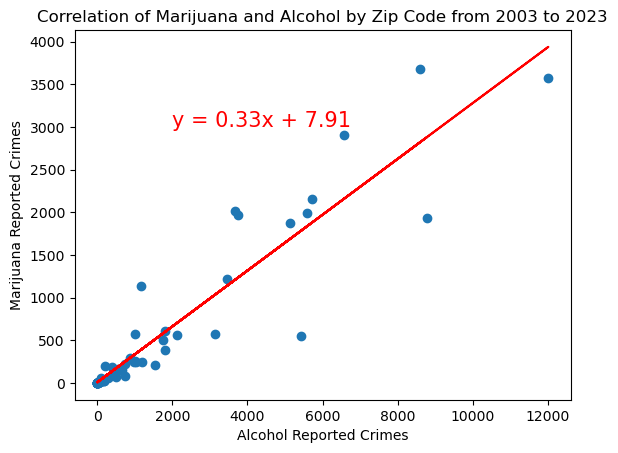

In [58]:
y=mj_oh["Marihuana"].astype('float')
x=mj_oh["Alcohol"].astype('float')

#linear regression
(slope,intercept,rvalue,pvalue,stderr)= linregress(x,y)
regress_values= x * slope + intercept
line_eq="y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

#plot
plt.scatter(x,y)
plt.plot(x,regress_values, "r-")
plt.title("Correlation of Marijuana and Alcohol by Zip Code from 2003 to 2023")
plt.xlabel("Alcohol Reported Crimes")
plt.ylabel("Marijuana Reported Crimes")
plt.annotate(line_eq,(2000,3000),fontsize=15,color="red")
#R value
print(f"The r-value is: {rvalue**2}")
#save image
plt.savefig("Output/Fig1.png")
plt.show

In [30]:
#Determine Correlation
y=mj_oh["Marihuana"]
x=mj_oh["Alcohol"]
correlation= st.pearsonr(x,y)
print(f"The correlation between both is {round(correlation[0],2)}")

The correlation between both is 0.93


In [32]:
zip_alc_df = pd.DataFrame(df_alcohol["Zip Code"].value_counts())
zip_alc_df.insert(1, "Latitude", "")
zip_alc_df.insert(2, "Longitude", "")

#len(zip_alc_df)
zip_alc_df.head()

Zip Code Latitude Longitude
78701.0     12011                   
78704.0      8778                   
78741.0      8588                   
78702.0      6574                   
78753.0      5712

In [33]:
zip_alc_df = zip_alc_df.rename(columns={"Zip Code": "Number of Reports"})
zip_alc_df.insert(3, "Zip Code", "")
zip_alc_df.head()

Number of Reports Latitude Longitude Zip Code
78701.0              12011                            
78704.0               8778                            
78741.0               8588                            
78702.0               6574                            
78753.0               5712

In [34]:
# Set parameters to search for zip long, lat

params = {
    "type":"postcode",
    "apiKey":geoapify_key
}

# Print a message to follow up the hotel search
print("Starting zip search")

for index, row in zip_alc_df.iterrows():
    
    # get Zip Code from the DataFrame, convert from float to object, drop decimal
    ind = str(index)[:-2]
    
    # Set base URL
    base_url = "https://api.geoapify.com/v1/geocode/search?text=" + ind


    # Make and API request using the params dictionaty
    name_address = requests.get(base_url, params=params)
    
    # Convert the API response to JSON format
    name_address = name_address.json()
    #print(json.dumps(name_address, indent=4))
    # break

    try:
        if name_address["features"][0]["properties"]["city"] == 'Austin':

            zip_alc_df.loc[index, "Zip Code"] = ind
    
            try:
                zip_alc_df.loc[index, "Latitude"] = name_address["features"][0]["properties"]["lat"]
                zip_alc_df.loc[index, "Longitude"] = name_address["features"][0]["properties"]["lon"]
            except (KeyError, IndexError):
                print("No Zip " + ind)
        else:
            #print("not in austin")
            zip_alc_df = zip_alc_df.drop(index=index)
    except (KeyError, IndexError):
        #print("Not in Austin")
        zip_alc_df = zip_alc_df.drop(index=index)
       
# Display sample data

zip_alc_df


Starting zip search


Number of Reports   Latitude  Longitude Zip Code
78701.0              12011  30.270412 -97.742935    78701
78704.0               8778   30.24443 -97.761613    78704
78741.0               8588  30.231028 -97.720128    78741
78702.0               6574  30.268695 -97.717508    78702
78753.0               5712  30.377821 -97.677421    78753
78745.0               5591  30.208502 -97.792182    78745
78703.0               5427  30.289265 -97.765464    78703
78758.0               5146  30.381173 -97.707097    78758
78744.0               3736  30.184489 -97.740816    78744
78723.0               3676  30.301331 -97.691979    78723
78752.0               3449  30.326247 -97.701883    78752
78759.0               3126  30.397221 -97.755883    78759
78705.0               2133  30.292294 -97.739032    78705
78748.0               1816  30.166067 -97.827793    78748
78757.0               1797  30.350628 -97.726463    78757
78751.0               1750  30.310407  -97.72382    78751
78731.0               1529  30.347193 -97.766098    78731
78721.0               1162  30.272728 -97.684916    78721
78749.0               1032  30.214137 -97.857517    78749
78727.0               1002  30.426108 -97.712963    78727
78724.0                994  30.287165 -97.621538    78724
78750.0                991  30.429426 -97.799737    78750
78722.0                879  30.287225 -97.718214    78722
78729.0                734  30.455208 -97.770236    78729
78756.0                653   30.31512 -97.740373    78756
78717.0                510  30.492725 -97.770826    78717
78747.0                495   30.14613 -97.749454    78747
78617.0                396  30.160732 -97.609364    78617
78726.0                296  30.433178 -97.840337    78726
78712.0                 98  30.285674 -97.735385    78712
78742.0                 98  30.234544 -97.675216    78742
78739.0                 93  30.173965  -97.88119    78739

In [ ]:
len(zip_alc_df)

32

In [ ]:
zip_mj_df = pd.DataFrame(df_mj["Zip Code"].value_counts())
zip_mj_df.insert(1, "Latitude", "")
zip_mj_df.insert(2, "Longitude", "")

len(zip_mj_df)

51

In [ ]:
zip_mj_df = zip_mj_df.rename(columns={"Zip Code": "Number of Reports"})
zip_mj_df.insert(3, "Zip Code", "")
zip_mj_df.head()

Number of Reports Latitude Longitude Zip Code
78741.0               3682                            
78701.0               3572                            
78702.0               2902                            
78753.0               2156                            
78723.0               2017

In [ ]:
# Set parameters to search for zip long, lat

params = {
    "type":"postcode",
    "apiKey":geoapify_key
}

# Print a message to follow up the hotel search
print("Starting zip search")

for index, row in zip_mj_df.iterrows():
    
    # get Zip Code from the DataFrame, convert from float to object, drop decimal
    ind = str(index)[:-2]
    
    # Set base URL
    base_url = "https://api.geoapify.com/v1/geocode/search?text=" + ind


    # Make and API request using the params dictionaty
    name_address = requests.get(base_url, params=params)
    
    # Convert the API response to JSON format
    name_address = name_address.json()
    #print(json.dumps(name_address, indent=4))
    # break

    try:
        if name_address["features"][0]["properties"]["city"] == 'Austin':

            zip_mj_df.loc[index, "Zip Code"] = ind
    
            try:
                zip_mj_df.loc[index, "Latitude"] = name_address["features"][0]["properties"]["lat"]
                zip_mj_df.loc[index, "Longitude"] = name_address["features"][0]["properties"]["lon"]
            except (KeyError, IndexError):
                print("No Zip " + ind)
        else:
            #print("not in austin")
            zip_mj_df = zip_mj_df.drop(index=index)
    except (KeyError, IndexError):
        #print("Not in Austin")
        zip_mj_df = zip_mj_df.drop(index=index)
       
# Display sample data

zip_mj_df

Starting zip search


Number of Reports   Latitude  Longitude Zip Code
78741.0               3682  30.231028 -97.720128    78741
78701.0               3572  30.270412 -97.742935    78701
78702.0               2902  30.268695 -97.717508    78702
78753.0               2156  30.377821 -97.677421    78753
78723.0               2017  30.301331 -97.691979    78723
78745.0               1998  30.208502 -97.792182    78745
78744.0               1973  30.184489 -97.740816    78744
78704.0               1938   30.24443 -97.761613    78704
78758.0               1870  30.381173 -97.707097    78758
78752.0               1222  30.326247 -97.701883    78752
78721.0               1138  30.272728 -97.684916    78721
78748.0                604  30.166067 -97.827793    78748
78724.0                577  30.287165 -97.621538    78724
78759.0                577  30.397221 -97.755883    78759
78705.0                567  30.292294 -97.739032    78705
78703.0                550  30.289265 -97.765464    78703
78751.0                500  30.310407  -97.72382    78751
78757.0                384  30.350628 -97.726463    78757
78722.0                292  30.287225 -97.718214    78722
78727.0                255  30.426108 -97.712963    78727
78750.0                250  30.429426 -97.799737    78750
78749.0                247  30.214137 -97.857517    78749
78729.0                221  30.455208 -97.770236    78729
78731.0                206  30.347193 -97.766098    78731
78617.0                182  30.160732 -97.609364    78617
78756.0                148   30.31512 -97.740373    78756
78747.0                133   30.14613 -97.749454    78747
78717.0                 66  30.492725 -97.770826    78717
78726.0                 56  30.433178 -97.840337    78726
78712.0                 32  30.285674 -97.735385    78712
78739.0                 23  30.173965  -97.88119    78739
78742.0                 19  30.234544 -97.675216    78742

In [ ]:
bar_oh=df_alcohol.groupby(['Zip Code','Location Type'])['Highest Offense Description'].count().sort_values(ascending=False)
#bar_oh.plot(kind='bar')
bar_oh1=pd.DataFrame(bar_oh).reset_index()
bar_oh1.head(20)

Zip Code                         Location Type  \
0    78701.0  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
1    78704.0  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
2    78741.0  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
3    78702.0  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
4    78703.0  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
5    78745.0  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
6    78753.0  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
7    78758.0  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
8    78744.0  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
9    78723.0  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
10   78752.0  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
11   78759.0  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
12   78705.0  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
13   78751.0  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
14   78748.0  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
15   78757.0  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
16   78731.0  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
17   78746.0  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
18   78721.0  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
19   78741.0             PARKING /DROP LOT/ GARAGE   

    Highest Offense Description  
0                         11273  
1                          7975  
2                          7228  
3                          6031  
4                          5300  
5                          5051  
6                          4931  
7                          4478  
8                          3358  
9                          3180  
10                         3019  
11                         2824  
12                         1867  
13                         1562  
14                         1559  
15                         1552  
16                         1378  
17                         1025  
18                         1021  
19                          933

In [ ]:
bar_oh1.plot(kind='line',figsize=(10,6))

2003    1011
2004     949
2005     877
2006     911
2007     910
2008    1023
2009    2255
2010    2501
2011    2281
2012    2371
2013    2396
2014    2203
2015    1926
2016    2309
2017    2538
2018    1989
2019    1248
2020     594
2021     379
2022     484
2023     154
Name: Occurred Date - Year, dtype: int64


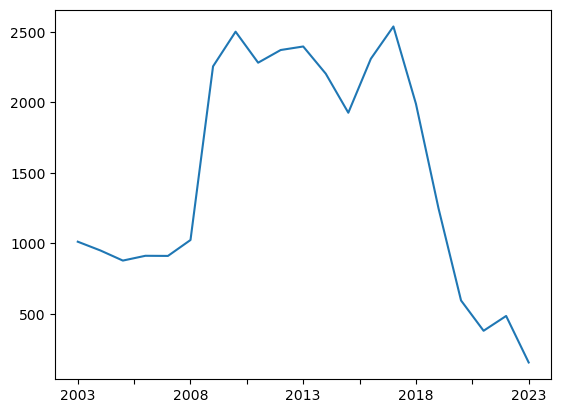

In [ ]:
df_mjCOUNT= df_mj["Occurred Date - Year"].value_counts().sort_index()
df_mjCOUNT.plot(kind='line')
print(df_mjCOUNT)

<AxesSubplot:>

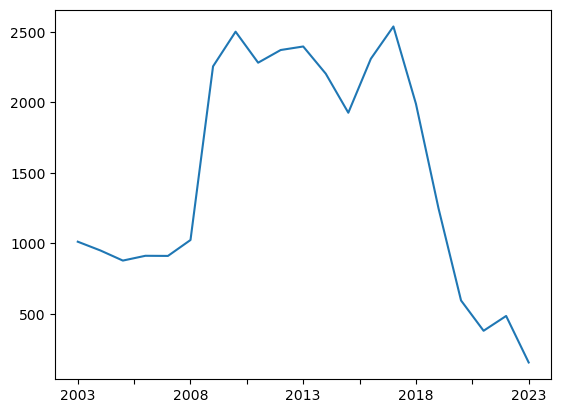

In [ ]:
df_mjCOUNT= df_mj["Occurred Date - Year"].value_counts().sort_index()
df_mjCOUNT.plot(kind='line')

[Text(0.5, 0, 'Zip Code'), Text(0, 0.5, 'Number of Crimes')]

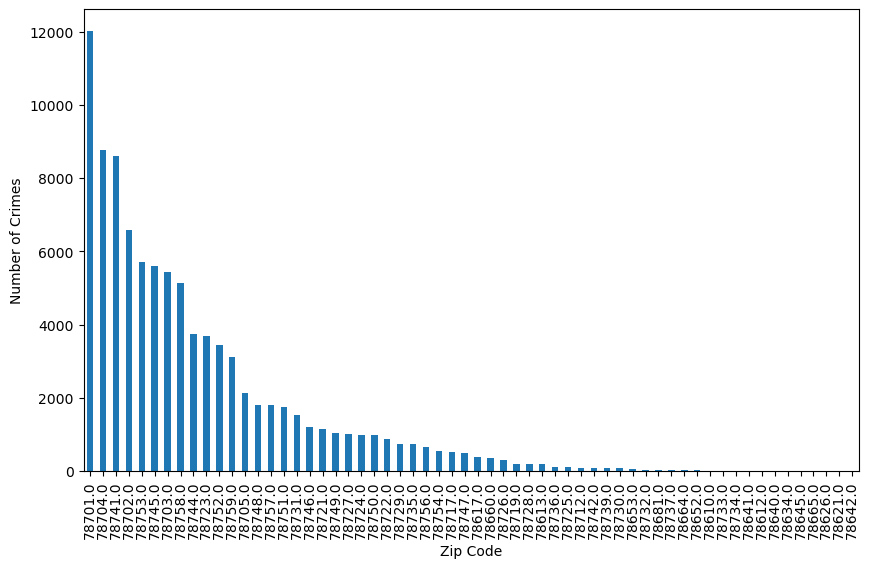

In [ ]:
df_ohCOUNT= df_alcohol["Zip Code"].value_counts().sort_values(ascending=False)
df_ohCOUNT.plot(kind='bar',figsize=(10,6)).set(xlabel="Zip Code",ylabel="Number of Crimes")

In [ ]:
df_ohCOUNT= df_alcohol["Zip Code"].value_counts().sort_index()
df_ohCOUNT.plot(kind='bar',figsize=(10,6)).set(xlabel="Zip Code",ylabel="Number of Crimes")

<function matplotlib.pyplot.show(close=None, block=None)>

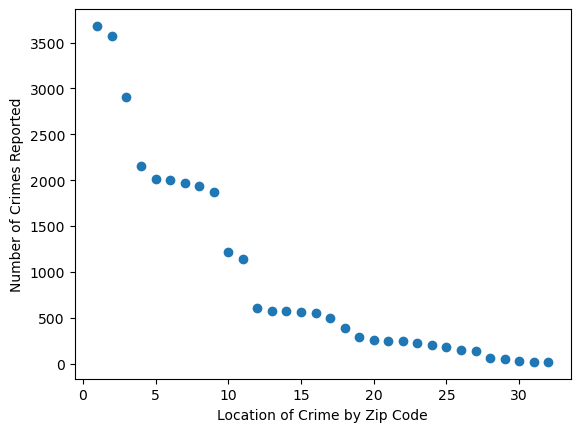

In [ ]:


#x=range(1,len(Top_mj)+1)
x=range(1,len(zip_mj_df)+1)
y=zip_mj_df["Number of Reports"]
plt.scatter(x,y)
plt.xlabel("Location of Crime by Zip Code")
plt.ylabel("Number of Crimes Reported")
plt.show

<AxesSubplot:>

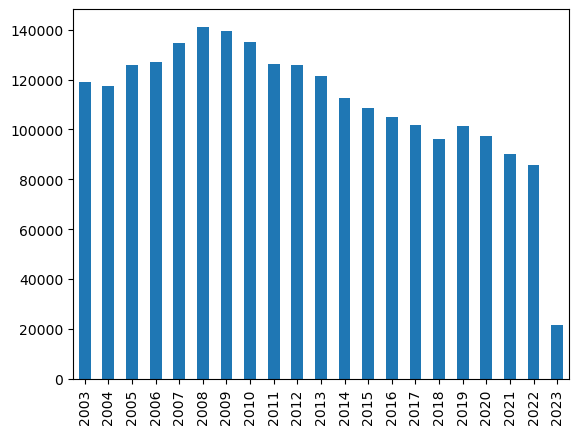

In [ ]:
# Show graph of number of crimes by year

crime_counts_by_year = clean_crime_loc_df["Occurred Date - Year"].value_counts().sort_index()
#crime_counts_by_year.sort_index(ascending=True)
crime_counts_by_year
crime_counts_by_year.plot(kind="bar")


<AxesSubplot:>

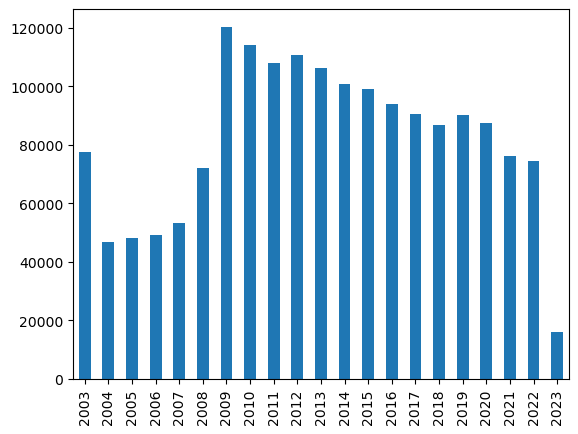

In [ ]:
# Show graph of number of crimes by year

crime_counts_by_year = clean_crime_df["Occurred Date - Year"].value_counts().sort_index()
#crime_counts_by_year.sort_index(ascending=True)
crime_counts_by_year
crime_counts_by_year.plot(kind="bar")

In [ ]:
time_night=clean_crime_df.loc[(clean_crime_df['Occurred Time']>= 2000.0) | (clean_crime_df['Occurred Time']<= 600.0)]
time_night

Highest Offense Description Occurred Date  Occurred Time  \
36277                    THEFT OF METAL    12/01/2022         2327.0   
36278            DOC UNREASONABLE NOISE    12/03/2022          500.0   
36279                             THEFT    10/29/2022         2300.0   
36280           CRED CARD ABUSE - OTHER    09/02/2022         2150.0   
36283         ASSAULT ON PUBLIC SERVANT    12/05/2022         2003.0   
...                                 ...           ...            ...   
2371174             BURGLARY OF VEHICLE    04/15/2009          600.0   
2371178  ASSAULT W/INJURY-FAM/DATE VIOL    11/30/2012         2100.0   
2371179              DATING DISTURBANCE    09/08/2003         2051.0   
2371182          BURGLARY NON RESIDENCE    11/20/2022          230.0   
2371191     VIOL CITY ORDINANCE - OTHER    06/06/2010           31.0   

        Occurred Date - Year                            Location Type  \
36277                   2022             COMMERCIAL / OFFICE BUILDING   
36278                   2022                         RESIDENCE / HOME   
36279                   2022                         RESIDENCE / HOME   
36280                   2022                         RESIDENCE / HOME   
36283                   2022  DRUG STORE / DOCTOR'S OFFICE / HOSPITAL   
...                      ...                                      ...   
2371174                 2009                         RESIDENCE / HOME   
2371178                 2012                         RESIDENCE / HOME   
2371179                 2003                         RESIDENCE / HOME   
2371182                 2022                     HOTEL / MOTEL / ETC.   
2371191                 2010     HWY / ROAD / ALLEY/ STREET/ SIDEWALK   

                             Address   Latitude  Longitude  Zip Code  \
36277                   300 W 6TH ST  30.269110 -97.745659   78701.0   
36278             11704 N LAMAR BLVD  30.386647 -97.684531   78758.0   
36279                   708 E 6TH ST  30.266186 -97.735585   78701.0   
36280             10208 IDA GROVE LN  30.502544 -97.753089   78717.0   
36283    11113 RESEARCH BLVD SVRD NB  30.405290 -97.743457   78759.0   
...                              ...        ...        ...       ...   
2371174         1611 J J SEABROOK DR  30.282050 -97.691588   78721.0   
2371178            7211 NORTHEAST DR  30.322123 -97.679236   78723.0   
2371179      12345 ALAMEDA TRACE CIR  30.431378 -97.747069   78727.0   
2371182          2700 GRACY FARMS LN  30.406717 -97.712969   78758.0   
2371191            675 E RUNDBERG LN  30.358489 -97.688952   78753.0   

        APD Sector APD District Clearance Status  
36277           GE            1                N  
36278           ED            4                N  
36279           GE            2                N  
36280           AD            5                N  
36283           AD            2                C  
...            ...          ...              ...  
2371174         CH            4                N  
2371178         ID            3                N  
2371179         AD            3                N  
2371182         AD            2                N  
2371191         ED            1                C  

[750248 rows x 12 columns]

In [ ]:
time_day=clean_crime_df.loc[(clean_crime_df['Occurred Time']>600.0) & (clean_crime_df['Occurred Time']<2000.0)]
time_day

Highest Offense Description Occurred Date  Occurred Time  \
36274           BURGLARY OF VEHICLE    12/01/2022         1130.0   
36281                    AUTO THEFT    11/23/2022         1400.0   
36282                    AUTO THEFT    09/27/2019         1200.0   
36284                    MAIL THEFT    11/26/2022         1537.0   
36288               THEFT FROM AUTO    11/03/2022         1300.0   
...                             ...           ...            ...   
2371185                       THEFT    07/11/2018         1500.0   
2371187                       THEFT    10/08/2010         1047.0   
2371188            DEBIT CARD ABUSE    09/24/2020         1200.0   
2371189         BURGLARY OF VEHICLE    03/19/2010         1900.0   
2371192         FORGERY AND PASSING    08/25/2010         1605.0   

        Occurred Date - Year                 Location Type  \
36274                   2022              RESIDENCE / HOME   
36281                   2022     PARKING /DROP LOT/ GARAGE   
36282                   2019     PARKING /DROP LOT/ GARAGE   
36284                   2022              RESIDENCE / HOME   
36288                   2022              RESIDENCE / HOME   
...                      ...                           ...   
2371185                 2018          SERVICE/ GAS STATION   
2371187                 2010               OTHER / UNKNOWN   
2371188                 2020               OTHER / UNKNOWN   
2371189                 2010                 FIELD / WOODS   
2371192                 2010  COMMERCIAL / OFFICE BUILDING   

                            Address   Latitude  Longitude  Zip Code  \
36274          1921 WILLOW CREEK DR  30.232680 -97.727425   78741.0   
36281    12190 N MOPAC EXPY SVRD SB  30.414006 -97.708671   78759.0   
36282             4631 AIRPORT BLVD  30.306088 -97.715062   78751.0   
36284        12300 RIATA TRACE PKWY  30.431056 -97.745113   78727.0   
36288             12113 METRIC BLVD  30.403869 -97.698004   78758.0   
...                             ...        ...        ...       ...   
2371185    1405 W WILLIAM CANNON DR  30.200149 -97.799351   78745.0   
2371187       404 RALPH ABLANEDO DR  30.174438 -97.792345   78748.0   
2371188            3800 DROSSETT DR  30.211876 -97.731707   78744.0   
2371189       2201 ANDREW ZILKER RD  30.265757 -97.770554   78746.0   
2371192             915 W OLTORF ST  30.243395 -97.764287   78704.0   

        APD Sector APD District Clearance Status  
36274           HE            2                N  
36281           AD            3                N  
36282           BA            5                C  
36284           AD            3                N  
36288           ED            4                N  
...            ...          ...              ...  
2371185         FR            3                N  
2371187         FR            3                N  
2371188         FR            6                N  
2371189         DA            1                N  
2371192         DA            2                N  

[971137 rows x 12 columns]

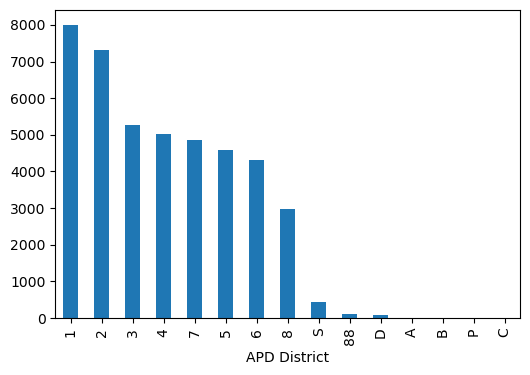

In [ ]:
bar1=year_2022.plot(kind="bar", figsize=(6,4))
plt.show()

In [ ]:
#zip=year2003_df["Zip Code"].nunique()
zip=clean_crime_df["Zip Code"].unique()
zip

array([78741., 78701., 78758., 78717., 78759., 78751., 78727., 78702.,
       78735., 78729., 78721., 78744., 78753., 78703., 78705., 78704.,
       78750., 78723., 78745., 78746., 78728., 78754., 78613., 78757.,
       78749., 78752., 78724., 78748., 78747., 78756., 78725., 78617.,
       78719., 78726., 78731., 78739., 78722., 78660., 78736., 78730.,
       78653., 78742., 78712., 78737., 78652., 78641., 78734., 78732.,
       78681., 78664., 78645., 78733., 78610., 78738.,     0., 78621.,
       78640., 78634., 78642., 76574., 78612., 78620., 78713., 78669.,
       78665., 78615., 78626., 78616., 78619.])

In [ ]:
District=clean_crime_df["Zip Code"].nunique()
District

69

In [ ]:
#PdD_2003=year2003_df.groupby(['Highest Offense Description','APD District'])['APD District'].count().sort_values(ascending=False)
PdD_2003=df_mj.groupby(['Highest Offense Description','Location Type'])
count=PdD_2003['Location Type'].count()
#pd.DataFrame(PdD_2003)
dist=pd.DataFrame(count.sort_values(ascending=False))
dist


Location Type
Highest Offense Description Location Type                                          
POSSESSION OF MARIJUANA     HWY / ROAD / ALLEY/ STREET/ SIDEWALK              20799
                            PARKING /DROP LOT/ GARAGE                          3263
                            RESIDENCE / HOME                                   2372
                            GOVERNMENT / PUBLIC BUILDING                        713
POSS SYNTHETIC MARIJUANA    HWY / ROAD / ALLEY/ STREET/ SIDEWALK                656
...                                                                             ...
                            CHURCH / SYNAGOGUE / TEMPLE / MOSQUE                  1
                            GAMBLING FACILITY / CASINO / RACE TRACK               1
POSSESSION OF MARIJUANA     DOCK / WHARF / FREIGHT / MODAL TERMINAL               1
                            ARENA / STADIUM / FAIRGROUNDS / COLISEUM              1
                            TRIBAL LANDS                                          1

[86 rows x 1 columns]

In [ ]:
PdD_2003=df_mj.groupby(['Highest Offense Description','Zip Code'])
count=PdD_2003['Highest Offense Description'].count()
#pd.DataFrame(PdD_2003)
dist=pd.DataFrame(count.sort_values(ascending=False))
dist

Highest Offense Description
Highest Offense Description Zip Code                             
POSSESSION OF MARIJUANA     78741.0                          3558
                            78701.0                          2990
                            78702.0                          2842
                            78753.0                          2108
                            78745.0                          1982
...                                                           ...
                            78734.0                             1
POSS SYNTHETIC MARIJUANA    78747.0                             1
                            78746.0                             1
                            78736.0                             1
DEL MARIJUANA               78756.0                             1

[120 rows x 1 columns]

In [ ]:
year_df = clean_crime_df.loc[clean_crime_loc_df["Occurred Date - Year"] == "2003", :]
crime_map_2003 = year_df.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    color="Zip Code"
    
)

crime_map_2003

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Zip Code)

In [ ]:
#D1Y2003df = df_mj.loc[(df_mj["Occurred Date - Year"] == "2003") & (clean_crime_loc_df['Highest Offense Description']=='BURGLARY OF VEHICLE')]
D1Y2003df = df_mj.loc[(df_mj["Occurred Date - Year"] == "2022")]
crime_d1_2009 = D1Y2003df.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    color="Zip Code"
    
)



crime_d1_2009

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Zip Code)

In [ ]:
D1Y2003df = df_mj.loc[(df_mj["Occurred Date - Year"] == "2022")]
crime_d1_2022 = D1Y2003df.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    color="APD District"
)

crime_d1_2022

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (APD District)

In [ ]:
D1Y2003df

Highest Offense Description Occurred Date  Occurred Time  \
54009           BURGLARY OF VEHICLE    12/03/2003         1200.0   
64210           BURGLARY OF VEHICLE    01/26/2003         2300.0   
66124           BURGLARY OF VEHICLE    08/23/2003         1723.0   
67078           BURGLARY OF VEHICLE    10/28/2003         2244.0   
68160           BURGLARY OF VEHICLE    10/28/2003         1300.0   
...                             ...           ...            ...   
2369939         BURGLARY OF VEHICLE    05/03/2003         2010.0   
2369950         BURGLARY OF VEHICLE    06/08/2003         1600.0   
2370263         BURGLARY OF VEHICLE    06/22/2003         1322.0   
2370470         BURGLARY OF VEHICLE    02/26/2003         1815.0   
2370860         BURGLARY OF VEHICLE    04/23/2003         1220.0   

        Occurred Date - Year                         Location Type  \
54009                   2003           DEPARTMENT / DISCOUNT STORE   
64210                   2003             PARKING /DROP LOT/ GARAGE   
66124                   2003                         FIELD / WOODS   
67078                   2003  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
68160                   2003                  SERVICE/ GAS STATION   
...                      ...                                   ...   
2369939                 2003             PARKING /DROP LOT/ GARAGE   
2369950                 2003  HWY / ROAD / ALLEY/ STREET/ SIDEWALK   
2370263                 2003            AIR / BUS / TRAIN TERMINAL   
2370470                 2003             PARKING /DROP LOT/ GARAGE   
2370860                 2003                         FIELD / WOODS   

                        Address   Latitude  Longitude  Zip Code APD Sector  \
54009    7510 ROBERT KLEBURG LN  30.225673 -97.872306   78749.0         DA   
64210     3400 N I 35 NB SVC RD  30.292273 -97.720973   78723.0         CH   
66124           1002 TILLERY ST  30.263749 -97.703492   78702.0         CH   
67078              4401 TERI RD  30.197790 -97.746426   78744.0         FR   
68160         3611 HILLBROOK DR  30.344435 -97.760502   78731.0         BA   
...                         ...        ...        ...       ...        ...   
2369939   5804 N I 35 SB SVC RD  30.319081 -97.707668   78751.0         BA   
2369950   5701 JOHNNY MORRIS RD  30.292222 -97.651921   78724.0         CH   
2370263  3600 PRESIDENTIAL BLVD  30.202008 -97.666881   78719.0         AP   
2370470        8801 N FM 620 RD  30.427462 -97.842637   78726.0         AD   
2370860           800 E 12TH ST  30.271944 -97.731859   78702.0         CH   

        APD District Clearance Status  
54009              6                C  
64210              6                N  
66124              2                O  
67078              5                N  
68160              8                N  
...              ...              ...  
2369939            4                N  
2369950            6                N  
2370263            S                N  
2370470            8                N  
2370860            3                N  

[7428 rows x 12 columns]

In [ ]:
D1Y2003df = clean_crime_df.loc[(clean_crime_loc_df["Occurred Date - Year"] == "2022") & (clean_crime_loc_df['APD District']=='1')]
crime_d1_2003 = D1Y2003df.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    frame_width = 700,
    frame_height = 500,
    color="Zip Code"
    
)

crime_d1_2003

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Zip Code)